# Example of Batching

We provide an example of how to update parameters on a batch of data. In these toy examples, we show different ways to update parameters of functions on data of multiple inputs. For simplicity, we consider batch update without sampling.

In [ ]:
!pip install trace-opt

First, we consider a small linear regression problem. To perform updates on multiple inputs at a time, here we just compute the loss for each input and then sum it up, and perform one `backward` call to tell the optimizer to minimize the loss. Since the optimizer is capable of seeing the graph, it understands that how different inputs and labels are paired and evaluated by the loss function.

In [1]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)

from opto import trace
from opto.optimizers import OptoPrime


def true_fun(x):
    return 2*x  - 3

inputs = [3, 2, 1, 5, 4]
outputs = [true_fun(x) for x in inputs]
N = len(inputs)


@trace.bundle()
def loss(y_hat, y):
    """ A least squares loss function. """
    return (y_hat - y) ** 2


def compute_loss(inputs, outputs):
    l = 0
    for x,y in zip(inputs, outputs):
        y_hat = fun(x)
        l += loss(y_hat, y)
    return l


Iteration 0 Loss: 85
Iteration 1 Loss: 10
Iteration 2 Loss: 10
Iteration 3 Loss: 8.3
Iteration 4 Loss: 9.6375
Iteration 5 Loss: 10
Iteration 6 Loss: 10
Iteration 7 Loss: 10
Iteration 8 Loss: 8.299999999999997
Iteration 9 Loss: 9.075
Iteration 10 Loss: 9.1375
Iteration 11 Loss: 9.622
Iteration 12 Loss: 10
Iteration 13 Loss: 6.599999999999999
Iteration 14 Loss: 9.350000000000001


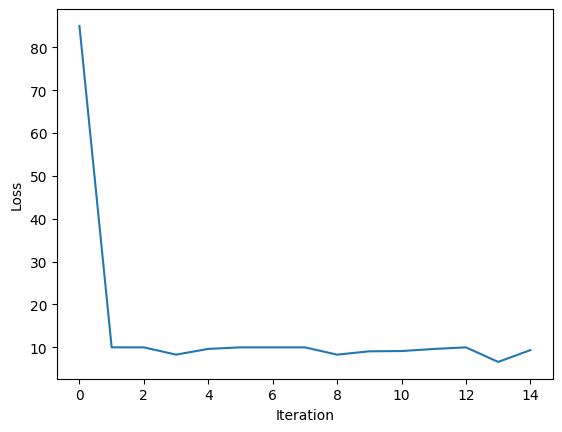

In [2]:
trace.GRAPH.clear()

@trace.bundle(trainable=True)
def fun(x):
    """ A linear predictor function """
    return 0

optimizer = OptoPrime(fun.parameters())

ls = []
for i in range(15):
    try:
        l = compute_loss(inputs, outputs)
        target = l
        feedback = 'Minimize loss'
        print(f'Iteration {i} Loss: {l.data}')
        ls.append(l.data)
    except trace.ExecutionError as e:
        target = e.exception_node
        feedback = str(e.exception_node.data)

    optimizer.zero_feedback()
    optimizer.backward(target, feedback)
    optimizer.step()

# plot ls
import matplotlib.pyplot as plt
plt.plot(ls)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In contrast, if we update the parameter without batching but in a purely online fashion one by one, then the optimization results can be more noisy sometimes.

Iteration 0 Loss: 85
Iteration 1 Loss: 15
Iteration 2 Loss: 10
Iteration 3 Loss: 30
Iteration 4 Loss: 30
Iteration 5 Loss: 30
Iteration 6 Loss: 15
Iteration 7 Loss: 30
Iteration 8 Loss: 30
Iteration 9 Loss: 15
Iteration 10 Loss: 10
Iteration 11 Loss: 10
Iteration 12 Loss: 15
Iteration 13 Loss: 30
Iteration 14 Loss: 10


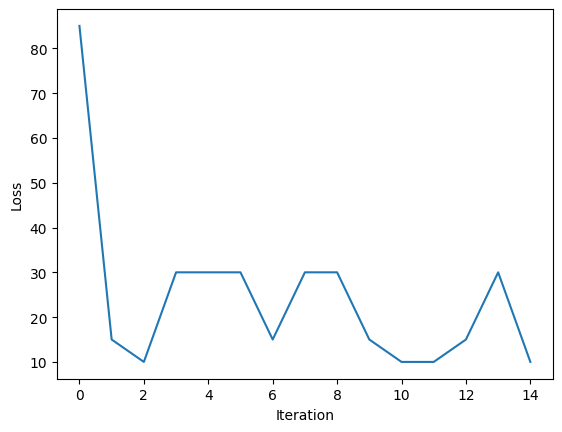

In [3]:


trace.GRAPH.clear()

@trace.bundle(trainable=True)
def fun(x):
    """ A linear predictor function """
    return 0

optimizer = OptoPrime(fun.parameters())

ls = []
for i in range(15):
    try:
        l_eval = compute_loss(inputs, outputs)
        print(f'Iteration {i} Loss: {l_eval.data}')
        ls.append(l_eval.data)

        ind = np.random.randint(0, N) % N
        target = compute_loss([inputs[ind]], [outputs[ind]])
        feedback = 'Minimize loss'
    except trace.ExecutionError as e:
        target = e.exception_node
        feedback = str(e.exception_node.data)

    optimizer.zero_feedback()
    optimizer.backward(target, feedback)
    optimizer.step()



# plot ls
import matplotlib.pyplot as plt
plt.plot(ls)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
